In [57]:
# calls yahoo finance api to download the daily stock prices
import yfinance as yf

In [58]:
#ticker class for price history, here GSPC is S&P index
sp500 = yf.Ticker("^GSPC")

In [59]:
#query the historical prices from the very beginning when the index was created
sp500_data =sp500.history(period="max")

<Axes: xlabel='Date'>

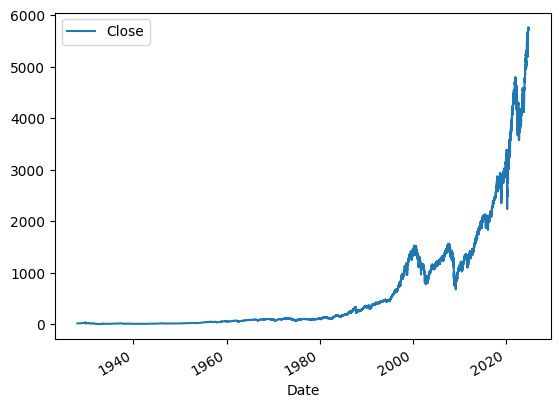

In [60]:
#plot the closing price against the index(the first colum is the index)
sp500_data.plot.line(y="Close",use_index=True)

In [61]:
#removing the columns we are not using to be using in the prediction:
#remove the divideds colum
sp500_data = sp500_data.drop(["Dividends"],axis=1)
#remove the stock split column
sp500_data =sp500_data.drop(["Stock Splits"],axis=1)

In [62]:
#create a column "Tomorrow" i.e., it will be tomorrow's price -> everyday has the nextday price in the tomorrow column
sp500_data = sp500_data.assign(Tomorrow=sp500.history(period="max").drop(["Dividends","Stock Splits"],axis=1).Close.shift(-1))


In [63]:
#based on tommorrow'a price we will be predicting a target where tomorrow is greater than closing price
sp500_data["Target"] = (sp500_data.Tomorrow > sp500_data.Close).astype(int)

In [64]:
sp500_data

Open         High          Low        Close  \
Date                                                                            
1927-12-30 00:00:00-05:00    17.660000    17.660000    17.660000    17.660000   
1928-01-03 00:00:00-05:00    17.760000    17.760000    17.760000    17.760000   
1928-01-04 00:00:00-05:00    17.719999    17.719999    17.719999    17.719999   
1928-01-05 00:00:00-05:00    17.549999    17.549999    17.549999    17.549999   
1928-01-06 00:00:00-05:00    17.660000    17.660000    17.660000    17.660000   
...                                ...          ...          ...          ...   
2024-09-30 00:00:00-04:00  5726.520020  5765.140137  5703.529785  5762.479980   
2024-10-01 00:00:00-04:00  5757.729980  5757.729980  5681.279785  5708.750000   
2024-10-02 00:00:00-04:00  5698.140137  5719.629883  5674.000000  5709.540039   
2024-10-03 00:00:00-04:00  5698.189941  5718.779785  5677.370117  5699.939941   
2024-10-04 00:00:00-04:00  5737.479980  5753.209961  5702.830078  5751.069824   

                               Volume     Tomorrow  Target  
Date                                                        
1927-12-30 00:00:00-05:00           0    17.760000       1  
1928-01-03 00:00:00-05:00           0    17.719999       0  
1928-01-04 00:00:00-05:00           0    17.549999       0  
1928-01-05 00:00:00-05:00           0    17.660000       1  
1928-01-06 00:00:00-05:00           0    17.500000       0  
...                               ...          ...     ...  
2024-09-30 00:00:00-04:00  4425730000  5708.750000       0  
2024-10-01 00:00:00-04:00  4025180000  5709.540039       1  
2024-10-02 00:00:00-04:00  3829050000  5699.939941       0  
2024-10-03 00:00:00-04:00  3597450000  5751.069824       1  
2024-10-04 00:00:00-04:00  3479400000          NaN       0  

[24307 rows x 7 columns]

In [65]:
#due to market trends shift in an interval we consider new data not the very old one
sp500_data = sp500_data.loc["1990-01-01":].copy()

> Till now the data set up and analysis is completed i.e., I removed unnecessary columns, added more columns for prediction and considered a subset for predictions.

Here I am using Random Forest Classifier for prediction:


1. It works by training a bunch of decision trees.
2. Random starting parameters and later on it averages the result of these trees.
3. Generally resistant to overfit our data.
4. Faster to run and train.
5. Pick up non-linearity from the data.



In [66]:
from sklearn.ensemble import RandomForestClassifier
# no of trees training, prevent overfitting, randomization-> same values assigned everytime
model = RandomForestClassifier(n_estimators=100,min_samples_split=100,random_state=1)

train = sp500_data.iloc[:-100] # all dataset except the last 100 rows - since we want to prevent information leakage here
test = sp500_data.iloc[-100:]  # last 100 rows are for test set

predictors = ["Close","Volume","Open","High","Low"]   # all columns used for predictions
model.fit(train[predictors],train["Target"])  # train the model- while predicting the target



RandomForestClassifier(min_samples_split=100, random_state=1)

In [72]:
#measuring the accuracy of the model i.e., was our prediction according to what actually happened to the stock market
from sklearn.metrics import precision_score, recall_score, f1_score

preds = model.predict(test[predictors])


In [74]:
import pandas as pd
recall = recall_score(test["Target"], preds)
print("Recall:", recall)
precision = precision_score(test["Target"], preds)
print("Precision:", precision)
f1 = f1_score(test["Target"], preds)
print("F1 Score:", f1)

preds = pd.Series(preds, index =test.index)

Recall: 0.016666666666666666
Precision: 1.0
F1 Score: 0.03278688524590164


1. High Precision (1.0): This means that whenever the model predicts a market increase (positive outcome), it is almost always correct. There are very few false positives (predicting an increase when there isn't one).
2. Extremely Low Recall (0.016666666666666666): This indicates that the model is missing a vast majority of the actual market increases (true positives). It is only capturing a very small percentage of the potential profitable opportunities.
3. Low F1 Score (0.03278688524590164): The F1 score, being a balanced measure of precision and recall, is also very low. This reflects the poor overall performance due to the extremely low recall, despite the high precision.

In [78]:
combined = pd.concat([test["Target"],preds],axis=1) # axis=1 : treat these inputs as columns


<Axes: xlabel='Date'>

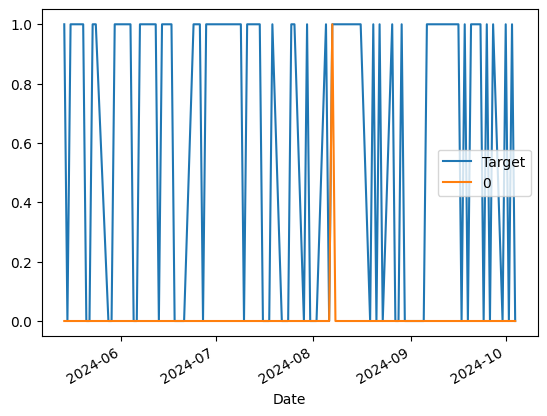

In [79]:
combined.plot()

In [81]:
#doing back testing - by prediction function:-
def predict(train,test,predictors,model):
  model.fit(train[predictors],train["Target"]) #training
  preds = model.predict(test[predictors]) # generating predictions
  preds = pd.Series(preds,index=test.index,name="Predictions")
  combined = pd.concat([test["Target"],preds],axis=1)
  return combined #returning dataframe with actual preditions

In [82]:
#write a backtest function - takesin data, model and predictions
# take 10 years of data and train it - then predict for 11th - then train for 11 and predict for 12th
def backtest(data,model,predictors,start=2500,step=250):
  all_predictions = []

  for i in range(start,data.shape[0],step): #looping across out data year by year
    train = data.iloc[0:i].copy()    #train set
    test = data.iloc[i:(i+step)].copy()    #test set
    predictions = predict(train,test,predictors,model)   # using the predict to generate "predictions"
    all_predictions.append(predictions)       # append it to tthe list
  return pd.concat(all_predictions)       #concat takes up the list and convert it to single dataframe

In [83]:
#now back test
predictions = backtest(sp500_data,model,predictors)

In [84]:
#evaluating errors of the predictions
predictions["Predictions"].value_counts() # how many times each was predicted

Predictions
0    3657
1    2600
Name: count, dtype: int64

In [86]:
recall = recall_score(predictions["Target"],predictions["Predictions"])
print("Recall:", recall)
precision = precision_score(predictions["Target"],predictions["Predictions"])
print("Precision:", precision)
f1 = f1_score(predictions["Target"],predictions["Predictions"])
print("F1 Score:", f1)

Recall: 0.4102028639618138
Precision: 0.5288461538461539
F1 Score: 0.4620295698924731


>The testing paramaters show that the model has a trade-off between precision and recall. While it's relatively precise in its positive predictions, it fails to capture a significant portion of actual market increases.

In [87]:
predictions["Target"].value_counts()/predictions.shape[0]

Target
1    0.53572
0    0.46428
Name: count, dtype: float64

## Adding additional predictors in the model to improve the accuracy

In [88]:
horizon = [2,5,60,250,1000]  #rolling means
#giving more info to the model for better learning and better performance
new_predictors = []
for horizon in horizon:    #loop through and calculate the rolling average againt the horizon
  rolling_averages = sp500_data.rolling(horizon).mean()

  ratio_column = f"Close_Ratio_{horizon}"
  sp500_data[ratio_column] = sp500_data["Close"] / rolling_averages["Close"]
  new_predictors.append(ratio_column)

  trend_column = f"Trend_{horizon}"     #no. of days the stock actually went up
  sp500_data[trend_column] = sp500_data.shift(1).rolling(horizon).sum()["Target"]    #finding the previous sum of all available
  new_predictors += [trend_column]


In [92]:
sp500_data = sp500_data.dropna()  #dropping NaN since it will cause problems in predictions later on

## Improving this Stock Market Prediction Model

In [93]:
model = RandomForestClassifier(n_estimators=200,min_samples_split=50,random_state=1)

In [94]:
def predict(train,test,predictors,model):
  model.fit(train[predictors],train["Target"])
  preds = model.predict_proba(test[predictors])[:,1] # returns the probability
  #setting custom threshold where the default is 0.5
  preds [preds >= 0.6] =1 # if there's 60% chance that price will go up -> it returns yes it goes up
  preds [preds < 0.6] =0  # if there's less than 60% chance that price will go up -> it returns no it does not
  preds = pd.Series(preds,index=test.index,name="Predictions")
  combined = pd.concat([test["Target"],preds],axis=1)
  return combined

In [95]:
#back test again
predictions = backtest(sp500_data,model,new_predictors)

Here while predicting the price itself is not as much important as much is the ration of the prices at different days.

In [96]:
predictions["Predictions"].value_counts()

Predictions
0.0    4409
1.0     847
Name: count, dtype: int64

This shows significant improvemt in our model i.e., we changed and experimented to induce more accuracy.

In [97]:
precision = precision_score(predictions["Target"],predictions["Predictions"])
print("Precision:", precision)
recall = recall_score(predictions["Target"],predictions["Predictions"])
print("Recall:", recall)
f1 = f1_score(predictions["Target"],predictions["Predictions"])
print("F1 Score:", f1)

Precision: 0.5749704840613932
Recall: 0.16986396930589467
F1 Score: 0.2622509423801831


This improvemt shows that actually 53% in the data the price went up but the model predicted it to be 57% in total and since it is pretty close to the actual trend hence this model has improved, given it was a time series data.